In [1]:
import urllib.request
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns

from library import AutoEDA
from library import Explore

from library import create_windowed_df
from library import make_fourier

In [2]:
# Convert the XML of the last 90 days of exchange rates from the ECB website to a pandas DataFrame

last_90 = "https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist-90d.xml?9531d63dc137832dc128c3fcc9bc4f12"

with urllib.request.urlopen(last_90) as response:
   xml_data = response.read()

root = ET.fromstring(xml_data)

df = pd.DataFrame(columns=['USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'CHF'],
                  dtype=np.dtype('float64'))
df.index = df.index.astype(np.dtype('datetime64[ns]'))

cube = root.find('{http://www.ecb.int/vocabulary/2002-08-01/eurofxref}Cube')

currencies_lst = ['USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'CHF']
dates = []
currencies_dict = {}

for child in cube:
    dates.append(child.attrib['time'])
    for rate_tag in child:
        currency = list(rate_tag.attrib.values())[0]
        rate = list(rate_tag.attrib.values())[1]
        if currency in currencies_lst:
            if currency in currencies_dict:
                currencies_dict[currency].append(rate)
            else:
                currencies_dict[currency] = [rate]

df = pd.DataFrame.from_dict(currencies_dict, dtype=np.dtype('float64'))
df['date'] = dates
df = df.set_index('date').rename_axis(None)
df.index = df.index.astype(np.dtype('datetime64[ns]'))

USD = df[['USD']]

df.head()

,USD,JPY,BGN,CZK,DKK,GBP,CHF
2024-04-04,1.0852,164.69,1.9558,25.322,7.4589,0.85788,0.9846
2024-04-03,1.0783,163.66,1.9558,25.352,7.4589,0.85713,0.9792
2024-04-02,1.0749,163.01,1.9558,25.361,7.4582,0.85510,0.9765
2024-03-28,1.0811,163.45,1.9558,25.305,7.4580,0.85510,0.9766
2024-03-27,1.0816,163.52,1.9558,25.319,7.4582,0.85768,0.9811


In [3]:
obj = AutoEDA(USD, 'USD')
dates_df = obj.append_datetime_cols()

fourier_df = make_fourier(dates_df, ['month', 'day', 'week_of_year', 'week_of_month', 'day_of_week'])
display(fourier_df.head())

# TODO: harmonic regression

,USD,year,month_sin1,month_cos1,day_sin1,day_cos1,week_of_year_sin1,week_of_year_cos1,week_of_month_sin1,week_of_month_cos1,day_of_week_sin1,day_of_week_cos1
2024-04-04,1.0852,2024,-2.449294e-16,1.000000e+00,0.724793,0.688967,-0.0,1.0,0.951057,0.309017,-0.951057,0.309017
2024-04-03,1.0783,2024,-2.449294e-16,1.000000e+00,0.571268,0.820763,-0.0,1.0,0.951057,0.309017,-0.587785,-0.809017
2024-04-02,1.0749,2024,-2.449294e-16,1.000000e+00,0.394356,0.918958,-0.0,1.0,0.951057,0.309017,0.587785,-0.809017
2024-03-28,1.0811,2024,-1.000000e+00,-1.836970e-16,-0.571268,0.820763,-0.433884,0.900969,-0.951057,0.309017,-0.951057,0.309017
2024-03-27,1.0816,2024,-1.000000e+00,-1.836970e-16,-0.724793,0.688967,-0.433884,0.900969,-0.951057,0.309017,-0.587785,-0.809017


In [4]:
# see https://www.youtube.com/watch?v=S_Z8RnTE5dI ~52:00 minute mark

eleven_window = create_windowed_df(USD, 10, 'USD')
display(eleven_window.head(11))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = eleven_window.drop('USD', axis=1)  
y = eleven_window['USD']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

predictions = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

,USD_t-10,USD_t-9,USD_t-8,USD_t-7,USD_t-6,USD_t-5,USD_t-4,USD_t-3,USD_t-2,USD_t-1,USD
2024-01-22,1.0946,1.0940,1.0946,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890
2024-01-23,1.0940,1.0946,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872
2024-01-24,1.0946,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905
2024-01-25,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893
2024-01-26,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871
2024-01-29,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823
2024-01-30,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846
2024-01-31,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846,1.0837
2024-02-01,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846,1.0837,1.0814
2024-02-02,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846,1.0837,1.0814,1.0883


Mean Squared Error: 2.0678955000002172e-05


## Data Augmentation

c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


<Axes: >

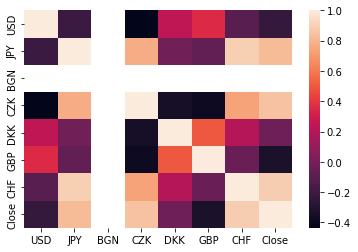

In [5]:
spy = yf.Ticker("SPY")
spy_hist = spy.history(period="6mo")
spy_hist = spy_hist[['Close']]
spy_hist.index = spy_hist.index.date

df_augmented = pd.merge(df, spy_hist, left_index=True, right_index=True, how='left')
df_augmented = df_augmented.dropna()

corr = df_augmented.corr()
sns.heatmap(corr)

# TODO: pca and scree plots